In this notebook we'll explore feature importance using SHAP values. SHAP values are the most mathematically consistent way for getting feature importances, and they work particulalry nicely with the tree-based models. Unfortunately, calculating SHAP values is an **extremely** resource intensive process. However, starting with XGBoost 1.3 it is possible to calcualte these values on GPUs, whcih speeds up the process by a factor of 20X - 50X compared to calculating the same on a CPU. Furthermore, it is also possible to calculate SHAP values for feature interactions. The GPU speedup for those is even more dramatic - it takes a few minutes, as opposed to days or even longer on a CPU.

In [1]:
%matplotlib inline


At this point the Kaaggle Docker environment does not support XGBoost 1.3+, so we'll have to install it manually.


In [2]:
!pip install --upgrade xgboost
import xgboost as xgb
xgb.__version__

     |████████████████████████████████| 157.5 MB 72 kB/s 
     |████████████████████████████████| 157.5 MB 61 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


'1.3.3'

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import shap

# load JS visualization code to notebook
shap.initjs()

In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2021/train.csv
/kaggle/input/tabular-playground-series-feb-2021/test.csv


In [5]:
train = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-feb-2021/sample_submission.csv')


In [6]:
columns = test.columns[1:]
columns


Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object')

In [7]:
target = train['target'].values

Let's applay label encoder to the categorical features.

In [8]:
cat_features = columns[:10]
cat_features

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9'],
      dtype='object')

In [9]:
for feature in cat_features:
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])

In [10]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,0,1,0,0,1,3,0,4,2,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,1,0,0,0,1,1,0,4,0,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,0,0,0,2,1,3,0,1,2,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,0,0,0,2,1,3,0,4,6,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,0,1,0,0,1,1,0,4,2,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [11]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,0,1,0,2,1,3,0,4,4,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,0,1,0,2,1,3,0,4,2,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,0,1,0,2,1,3,0,4,2,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,0,0,1,0,1,3,0,4,4,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,0,1,0,0,1,1,0,4,4,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


In [12]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

(300000,)

In [13]:
xgb_params= {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": 2001,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    }

In [14]:
test = xgb.DMatrix(test[columns])

In [15]:
NUM_FOLDS = 10
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
        #print(f'Fold {f}')
        train_df, val_df = train.iloc[train_ind][columns], train.iloc[val_ind][columns]
        train_target, val_target = target[train_ind], target[val_ind]
        
        train_df = xgb.DMatrix(train_df, label=train_target)
        val_df = xgb.DMatrix(val_df, label=val_target)
        
        model =  xgb.train(xgb_params, train_df, 3600)
        temp_oof = model.predict(val_df)
        temp_test = model.predict(test)

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

1it [00:32, 32.56s/it]

0.8400053409573499


2it [01:04, 32.25s/it]

0.8460532181914472


3it [01:36, 32.31s/it]

0.8418929429766825


4it [02:08, 32.04s/it]

0.83917410759575


5it [02:40, 31.93s/it]

0.846529768562444


6it [03:13, 32.36s/it]

0.8402277044792966


7it [03:46, 32.70s/it]

0.8412068860942079


8it [04:19, 32.79s/it]

0.839189236770389


9it [04:52, 32.80s/it]

0.8454855659577204


10it [05:25, 32.58s/it]

0.8414775217404592


In [16]:
0.8434888431362352

0.8434888431362352

In [17]:
mean_squared_error(train_oof, target, squared=False)


0.8421285553726264

In [18]:
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

Next, we calculate the SHAP values for the test set.



In [19]:
%%time
shap_preds = model.predict(test, pred_contribs=True)

CPU times: user 14.6 s, sys: 29.2 ms, total: 14.7 s
Wall time: 14.7 s


Now let's do some plots of these values.

In [20]:
train = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')
for feature in cat_features:
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])

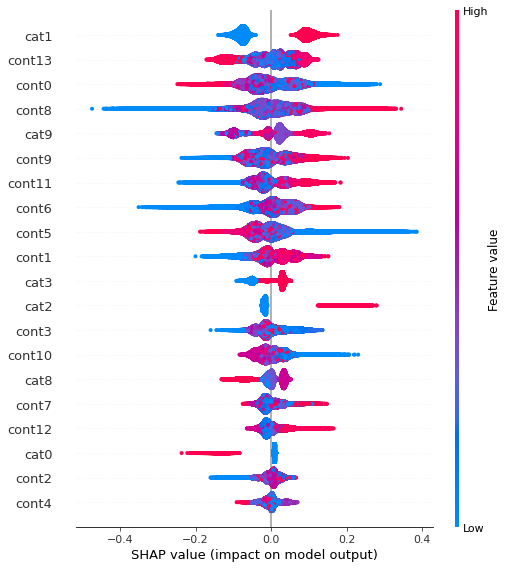

In [21]:
# summarize the effects of all the features
shap.summary_plot(shap_preds[:,:-1], test[columns])

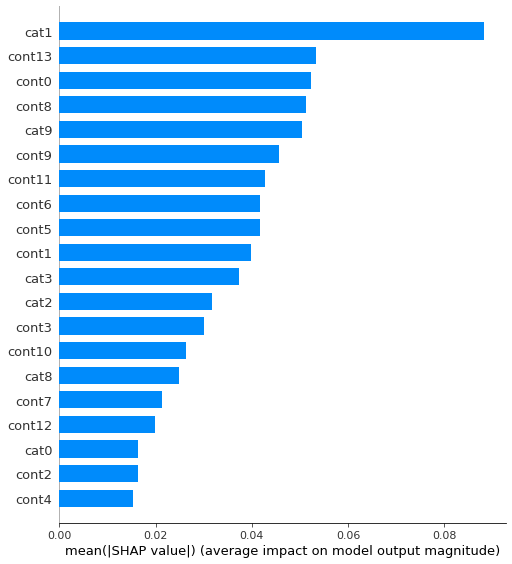

In [22]:
shap.summary_plot(shap_preds[:,:-1], test[columns], plot_type="bar")


Next, we'll calculate SHAP values for featue interactions. There will be 24x24x200,000 + 200,000 numbers that need to be computed.

In [23]:
%%time
shap_interactions = model.predict(xgb.DMatrix(test[columns]), pred_interactions=True)

CPU times: user 1min 47s, sys: 589 ms, total: 1min 48s
Wall time: 1min 48s


It took less than 2 minutes to calculate these values. On CPU this would take up to a day to compute.

Now let's take a look at what are the top interactions in this dataset.

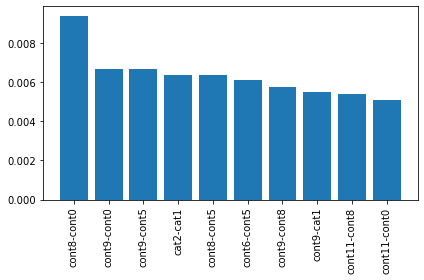

In [24]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_top_k_interactions(columns, shap_interactions, 10)


In [25]:
np.unique(train['cat1'])

array([0, 1])

In [26]:
np.unique(train['cat2'])

array([0, 1])

We will now construct 5 more features out of the top 5 most interactive ones.

In [27]:
train['cont8_cont0'] = train['cont8']*train['cont0']
train['cont9_cont0'] = train['cont9']*train['cont0']
train['cont9_cont5'] = train['cont9']*train['cont5']
train['cont8_cont5'] = train['cont8']*train['cont5']
train['cat2_cat1'] = train['cat2']*train['cat1']

test['cont8_cont0'] = test['cont8']*test['cont0']
test['cont9_cont0'] = test['cont9']*test['cont0']
test['cont9_cont5'] = test['cont9']*test['cont5']
test['cont8_cont5'] = test['cont8']*test['cont5']
test['cat2_cat1'] = test['cat2']*test['cat1']

In [28]:
del shap_interactions, shap_preds
gc.collect()
gc.collect()

0

In [29]:
columns = test.columns[1:]
target = train['target'].values
columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'cont8_cont0', 'cont9_cont0', 'cont9_cont5', 'cont8_cont5',
       'cat2_cat1'],
      dtype='object')

In [30]:
train_oof_2 = np.zeros((300000,))
test_preds_2 = 0
train_oof_2.shape

(300000,)

In [31]:
test = xgb.DMatrix(test[columns])

In [32]:
xgb_params= {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": 2001,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    }

In [33]:
NUM_FOLDS = 10
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
        #print(f'Fold {f}')
        train_df, val_df = train.iloc[train_ind][columns], train.iloc[val_ind][columns]
        train_target, val_target = target[train_ind], target[val_ind]
        
        train_df = xgb.DMatrix(train_df, label=train_target)
        val_df = xgb.DMatrix(val_df, label=val_target)
        
        model =  xgb.train(xgb_params, train_df, 3600)
        temp_oof = model.predict(val_df)
        temp_test = model.predict(test)

        train_oof_2[val_ind] = temp_oof
        test_preds_2 += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

1it [00:33, 33.86s/it]

0.8399835885206924


2it [01:07, 33.89s/it]

0.8465830253112416


3it [01:41, 33.95s/it]

0.8419329521369134


4it [02:15, 33.86s/it]

0.8393334647260561


5it [02:49, 33.88s/it]

0.8468614845890731


6it [03:23, 33.87s/it]

0.8407164851156022


7it [03:56, 33.80s/it]

0.841330564055547


8it [04:30, 33.86s/it]

0.839450261258617


9it [05:05, 34.13s/it]

0.8459146571213696


10it [05:39, 33.96s/it]

0.8417871413152782


In [34]:
mean_squared_error(train_oof_2, target, squared=False)


0.8423940080873971

In [35]:
mean_squared_error(0.5*train_oof+0.5*train_oof_2, target, squared=False)


0.8421397655352226

In [36]:
np.save('train_oof_2', train_oof_2)
np.save('test_preds_2', test_preds_2)

Now let's see what are the SHAP values for this model

In [37]:
%%time
shap_preds = model.predict(test, pred_contribs=True)

CPU times: user 15.7 s, sys: 32.1 ms, total: 15.7 s
Wall time: 15.7 s


In [38]:
train = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')
for feature in cat_features:
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])
    
train['cont8_cont0'] = train['cont8']*train['cont0']
train['cont9_cont0'] = train['cont9']*train['cont0']
train['cont9_cont5'] = train['cont9']*train['cont5']
train['cont8_cont5'] = train['cont8']*train['cont5']
train['cat2_cat1'] = train['cat2']*train['cat1']

test['cont8_cont0'] = test['cont8']*test['cont0']
test['cont9_cont0'] = test['cont9']*test['cont0']
test['cont9_cont5'] = test['cont9']*test['cont5']
test['cont8_cont5'] = test['cont8']*test['cont5']
test['cat2_cat1'] = test['cat2']*test['cat1']
columns = test.columns[1:]

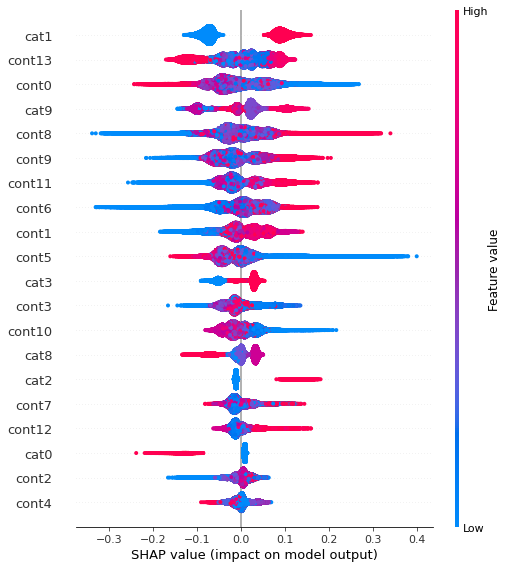

In [39]:
# summarize the effects of all the features
shap.summary_plot(shap_preds[:,:-1], test[columns])

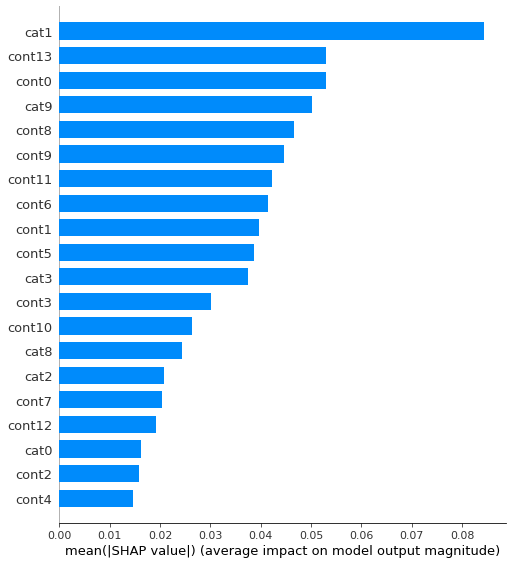

In [40]:
shap.summary_plot(shap_preds[:,:-1], test[columns], plot_type="bar")


In [41]:
sub['target'] = test_preds
sub.to_csv('submission.csv', index=False)

In [42]:
sub['target'] = test_preds_2
sub.to_csv('submission_2.csv', index=False)

In [43]:
sub['target'] = 1.1*test_preds-0.1*test_preds_2
sub.to_csv('submission_average_0.csv', index=False)

In [44]:
sub['target'] = 1.2*test_preds-0.2*test_preds_2
sub.to_csv('submission_average_1.csv', index=False)

In [45]:
sub['target'] = 1.3*test_preds-0.3*test_preds_2
sub.to_csv('submission_average_2.csv', index=False)